In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#Data
file_path = "./python-data-analysis-master/data/market-price.csv"
bitcoin_df = pd.read_csv(file_path, names = ['day','price'])

#기본정보 출력
print(bitcoin_df.shape)
print(bitcoin_df.info())
bitcoin_df.tail()

(365, 2)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   day     365 non-null    object 
 1   price   365 non-null    float64
dtypes: float64(1), object(1)
memory usage: 5.8+ KB
None


,day,price
360,2018-08-22 00:00:00,6575.229167
361,2018-08-23 00:00:00,6434.881667
362,2018-08-24 00:00:00,6543.645714
363,2018-08-25 00:00:00,6719.429231
364,2018-08-26 00:00:00,6673.274167


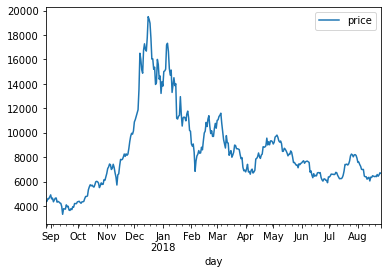

In [2]:
#to_datetime 으로 day 피쳐를 시계열로 전환
bitcoin_df['day'] = pd.to_datetime(bitcoin_df['day'])

#day 데이터 프레임을 idx 로 지정
bitcoin_df.index = bitcoin_df['day']
bitcoin_df.set_index('day', inplace = True)

#일자별 비트코인 시세를 시각화

bitcoin_df.plot()
plt.show()


### Arima 모델 (AR 자기 자신의 과거 정보를 사용하는 개념 ,차분: 추세변동의 경향성, MA 이전항에서의 오차를 이용하여 현재 항의 상태 추론)

In [3]:
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
#(AR =2 , 차분 = 1, MA = 2) Arima 모델 학습
model = ARIMA(bitcoin_df.price.values, order = (2,1,2)) #order = (p, d, q) 합이 2미만인 경우 p 와 q곱이 0을 포함한 짝수인 경우가 좋은 파라미터이다 
model_fit = model.fit(trend = 'c', full_output = True, disp = True)
print(model_fit.summary())

C:\Users\user\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                  364
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -2787.553
Method:                       css-mle   S.D. of innovations            512.415
Date:                Thu, 08 Jul 2021   AIC                           5587.107
Time:                        23:47:28   BIC                           5610.490
Sample:                             1   HQIC                          5596.400
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.3504     27.794      0.228      0.819     -48.125      60.826
ar.L1.D.y     -0.3788      1.827     -0.207      0.836      -3.960       3.202
ar.L2.D.y      0.1585      1.191      0.133      0.8

C:\Users\user\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


<AxesSubplot:>

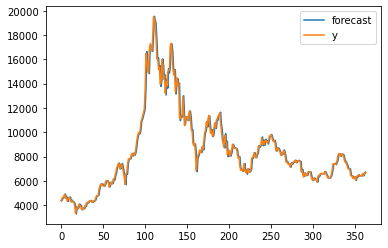

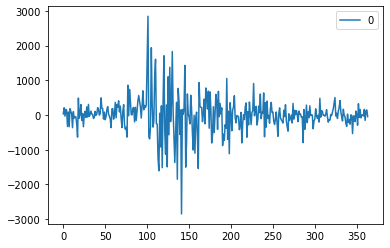

In [4]:
#Arima 모델 활용 : 모델의 성능 & 예측 결과 시각화
fig  = model_fit.plot_predict()
#잔차의 변동성이 매우 불안정하다 '앞으로 어느정도로 상승/하락 할것이다 예측 먼미래 x'
residuals = pd.DataFrame(model_fit.resid) #잔차의 변동 시각화
residuals.plot()

In [5]:
#이게 예측데이터
forecast_data = model_fit.forecast(steps = 5)
forecast_data

(array([6676.91465513, 6685.04372349, 6690.29068547, 6697.34116438,
        6703.25144429]),
 array([ 512.41529733,  753.50283147,  914.97539715, 1061.45038743,
        1184.4352922 ]),
 array([[5672.59912724, 7681.23018302],
        [5208.20531156, 8161.88213543],
        [4896.97186032, 8483.60951062],
        [4616.93663363, 8777.74569512],
        [4381.80092957, 9024.70195902]]))

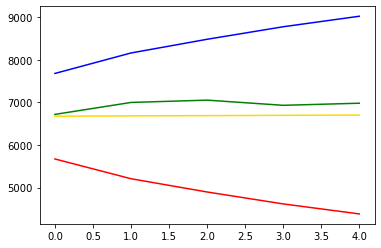

In [6]:


#테스트 데이터셋을 불러온다 
test_filepath = "./python-data-analysis-master/data/market-price-test.csv"
bitcoin_test_df = pd.read_csv(test_filepath,names = ['ds','y'] )

pred_y = forecast_data[0].tolist() #마지막 5일의 예측 데이터
test_y = bitcoin_test_df.y.values

pred_y_lower = [] #마지막 5일의 예측 데이터 최소값
pred_y_upper = [] #마지막 5일의 예측 데이터 최대값
for lower_upper in forecast_data[2]:
    lower = lower_upper[0]
    upper = lower_upper[1]
    pred_y_lower.append(lower)
    pred_y_upper.append(upper)

plt.plot(pred_y, color = 'gold')
plt.plot(pred_y_lower, color = 'r')
plt.plot(pred_y_upper, color = 'b')
plt.plot(test_y, color = 'g')






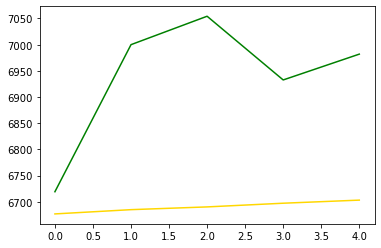

In [8]:
plt.plot(pred_y, color = 'gold')
plt.plot(test_y, color = 'g')

### Additive 모델 
- 선형회귀분석의 단점을 극복하기 위해 개량된 분석 방법의 하나 
- 회귀분석이 한 갤래이기 때문에 회귀 분석의 단점이 있다 따라서 각 피처마다 비선형적 적합을 가능하게하는일력의 방법을 적용

fbprophet 라이브러리 사용 데이터 프레임 피쳐를: 'ds'와 'y' 

In [7]:
from fbprophet import Prophet

#prophet을 사용하기 위해서는 다음과 같이 피쳐명을 변경
bitcoin_df =pd.read_csv(file_path, names = ['ds', 'y'])

prophet =Prophet(seasonality_mode="multiplicative",
                yearly_seasonality=True,
                weekly_seasonality=True,
                daily_seasonality=True,
                changepoint_prior_scale=0.5)
prophet.fit(bitcoin_df)





In [8]:
bitcoin_df

,ds,y
0,2017-08-27 00:00:00,4354.308333
1,2017-08-28 00:00:00,4391.673517
2,2017-08-29 00:00:00,4607.985450
3,2017-08-30 00:00:00,4594.987850
4,2017-08-31 00:00:00,4748.255000
...,...,...
360,2018-08-22 00:00:00,6575.229167
361,2018-08-23 00:00:00,6434.881667
362,2018-08-24 00:00:00,6543.645714
363,2018-08-25 00:00:00,6719.429231


In [10]:
#5일을 내다보며 예측 
future_data = prophet.make_future_dataframe(periods=5, freq = 'd')
forecast_data = prophet.predict(future_data)
forecast_data[['ds','yhat','yhat_lower','yhat_upper']].tail(5)

,ds,yhat,yhat_lower,yhat_upper
365,2018-08-27,6899.724550,6234.887218,7573.403084
366,2018-08-28,6990.060163,6288.736444,7650.408970
367,2018-08-29,7001.125569,6265.694443,7660.253394
368,2018-08-30,7070.236574,6352.231047,7862.897792
369,2018-08-31,7138.333532,6383.561973,7937.109653


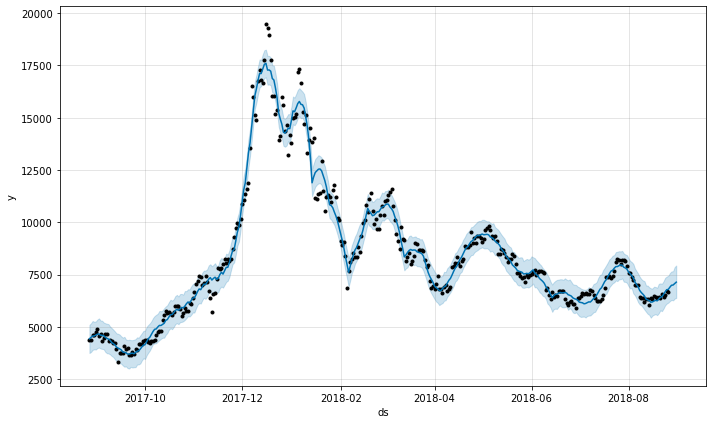

In [11]:
fig1 = prophet.plot(forecast_data)

C:\Users\user\anaconda3\lib\site-packages\fbprophet\plot.py:422: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(yticklabels)
C:\Users\user\anaconda3\lib\site-packages\fbprophet\plot.py:422: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(yticklabels)
C:\Users\user\anaconda3\lib\site-packages\fbprophet\plot.py:422: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(yticklabels)


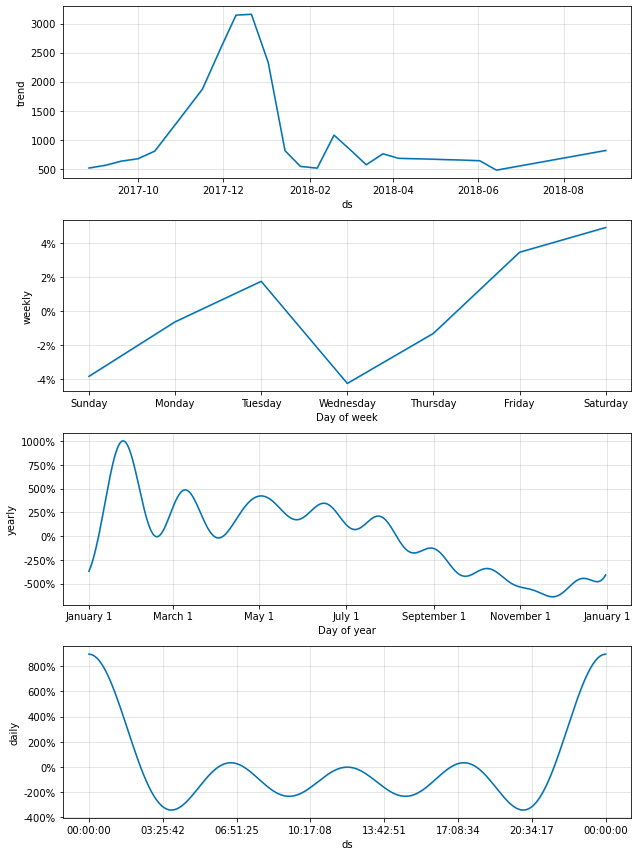

In [13]:
#트렌드를 알수 있다 
fig2 = prophet.plot_components(forecast_data)

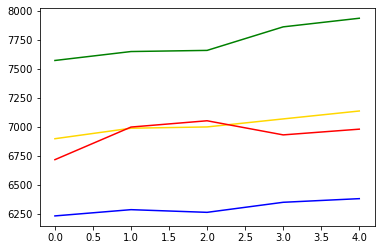

In [20]:
#Facebook Prophet : 실제 데이터와의 비교
bitcoin_test_df = pd.read_csv(test_filepath, names = ['ds','y'])

#마지막 5일의 예측 데이터 (2018-08-27 ~ 2018-08-31)
pred_y = forecast_data.yhat.values[-5:]

#실제 5일 가격 데이터 
test_y = bitcoin_test_df.y.values

#마지막 5일 예측 데이터 최소값
pred_y_lower = forecast_data.yhat_lower.values[-5:]
pred_y_upper = forecast_data.yhat_upper.values[-5:]

plt.plot(pred_y , color = 'gold')
plt.plot(test_y , color = 'red')
plt.plot(pred_y_lower , color = 'blue')
plt.plot(pred_y_upper , color = 'green')

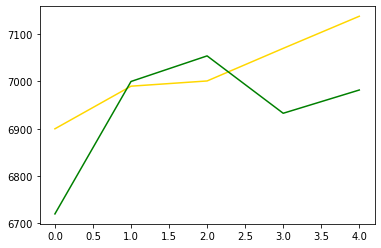

In [21]:
plt.plot(pred_y, color = 'gold') #모델이 예상한 가격 그래프
plt.plot(test_y, color = 'green') #실제가격 그래프

In [26]:
from math import sqrt
from sklearn.metrics import mean_squared_error
rmse = sqrt(mean_squared_error(pred_y, test_y))
rmse

125.59735772191783

### 더 나은 결과를 위한 방법
- 상한값 혹은 하한값을 지정해주는것 (상한값 혹은 하한값을 설정해주는 것이 모델성능을 높여줄수 있다

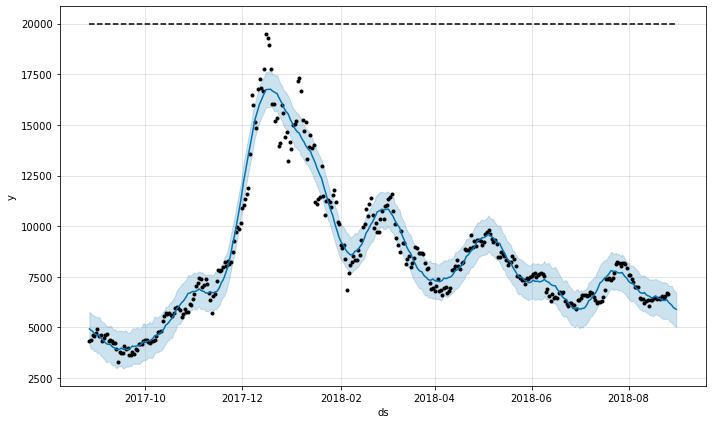

In [31]:
from fbprophet import Prophet

bitcoin_df = pd.read_csv(file_path, names = ['ds', 'y'])

#상한가를 설정
bitcoin_df['cap'] = 20000
prophet = Prophet(seasonality_mode='multiplicative',
                 growth = 'logistic',
                 yearly_seasonality=True,
                 weekly_seasonality=True,daily_seasonality=True,
                  changepoint_prior_scale=0.5
                 )

prophet.fit(bitcoin_df)

# 5일을 내다보며 예측합니다 
future_data = prophet.make_future_dataframe(periods=5, freq='d')

#상한가 설정
future_data['cap'] =20000 #prophet 모델은 cap 피쳐를 넣으면 상한가를 설정해줄수 있다 
forecast_data = prophet.predict(future_data)

fig = prophet.plot(forecast_data)

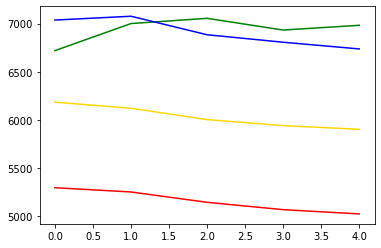

In [35]:
#예측과 실제 비교 그래프
bitcoin_test_df = pd.read_csv(test_filepath, names=['ds','y'])

#모델이 예측한 마지막 5일의 가격 데이터를 가져온다
pred_y = forecast_data.yhat.values[-5:]
#실제 5일 가격 데이터 
test_y = bitcoin_test_df.y.values

#마지막 5일 예측 데이터 최소값
pred_y_lower = forecast_data.yhat_lower.values[-5:]
pred_y_upper = forecast_data.yhat_upper.values[-5:]

plt.plot(pred_y , color = 'gold')
plt.plot(test_y , color = 'green')
plt.plot(pred_y_lower , color = 'red')
plt.plot(pred_y_upper , color = 'blue')

#형편없는 예측을 했다 실제 데이터가 상한값보다도 더 높기 때문이다 

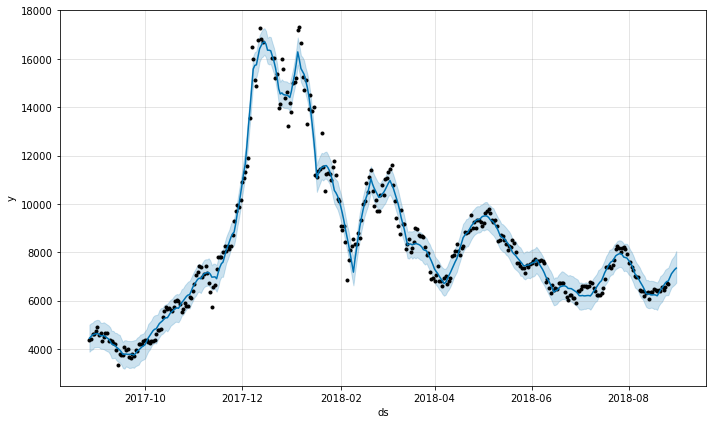

In [49]:
#이상치 제거 방법

#18000 이상의 데이터는 이상치라고 판단
bitcoin_df = pd.read_csv(file_path, names = ['ds','y'])
bitcoin_df.loc[bitcoin_df['y'] > 17500, 'y'] = None

#prophet 모델 학습
prophet = Prophet(seasonality_mode='multiplicative',
                 yearly_seasonality=True,
                 weekly_seasonality=True,
                 daily_seasonality=True,
                 changepoint_prior_scale=0.5)

prophet.fit(bitcoin_df)

#5일 단위의 미래를 예측
future_data = prophet.make_future_dataframe(periods=5, freq = 'd')
forecast_data = prophet.predict(future_data)

#예측 결과를 그래프로 출력합니다
fig = prophet.plot(forecast_data)

In [50]:
bitcoin_df

,ds,y
0,2017-08-27 00:00:00,4354.308333
1,2017-08-28 00:00:00,4391.673517
2,2017-08-29 00:00:00,4607.985450
3,2017-08-30 00:00:00,4594.987850
4,2017-08-31 00:00:00,4748.255000
...,...,...
360,2018-08-22 00:00:00,6575.229167
361,2018-08-23 00:00:00,6434.881667
362,2018-08-24 00:00:00,6543.645714
363,2018-08-25 00:00:00,6719.429231


928.7985564553254

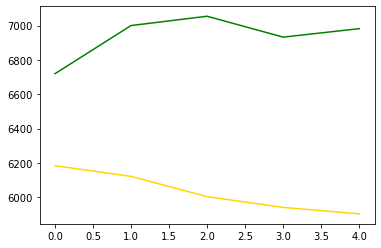

In [51]:
plt.plot(pred_y, color = 'gold') #모델이 예측한 가격 그래프
plt.plot(test_y, color = 'green') #실제 가격 그래프입니다 

#RMSE
rmse = sqrt(mean_squared_error(pred_y, test_y))
rmse

In [52]:
future_data

,ds
0,2017-08-27
1,2017-08-28
2,2017-08-29
3,2017-08-30
4,2017-08-31
...,...
365,2018-08-27
366,2018-08-28
367,2018-08-29
368,2018-08-30


In [57]:
bitcoin_df[bitcoin_df['y'] != None].loc[[:],'ds']

SyntaxError: invalid syntax (<ipython-input-57-aa8ee79dda30>, line 1)